# Disclaimer:

DeepSphere.AI developed these
materials based on its team’s expertise
and technical infrastructure, and we
are sharing these materials strictly for
learning and research. These learning
resources may not work on other learning
infrastructures and DeepSphere.AI
advises the learners to use these materials
at their own risk. As needed, we will be
changing these materials without any
notification and we have full ownership
and accountability to make any change
to these materials.

# Import Libraries and Set Configurations

In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

# Class KnowledgeGraph

In [2]:
class KnowledgeGraph:
  def __init__(self, vAR_candidate_sentences):
    #constructor
    #vAR_candidate_sentences - csv input file
    self.vAR_nlp = spacy.load('en_core_web_sm') #load spacy
    self.vAR_candidate_sentences = vAR_candidate_sentences
    self.vAR_entity_pairs = []
    self.vAR_kg_df = None
    self.vAR_relations = None

  def display_samples(self):
    #method to display samples
    print(self.vAR_candidate_sentences['sentence'].sample(5))

  def tokenize(self, vAR_doc):
    #method to tokenize the input vAR_doc
    vAR_doc = self.vAR_nlp("the drawdown process is governed by astm standard d823")

    for tok in vAR_doc:
      print(tok.text, "...", tok.dep_)

  def get_entities(self, vAR_sent):
    #method to get entities from input sentence
    ## chunk 1
    vAR_ent1 = ""
    vAR_ent2 = ""

    vAR_prv_tok_dep = ""    # dependency tag of previous token in the sentence
    vAR_prv_tok_text = ""   # previous token in the sentence

    vAR_prefix = ""
    vAR_modifier = ""

    #############################################################
    
    for tok in self.vAR_nlp(vAR_sent):
      ## chunk 2
      # if token is a punctuation mark then move on to the next token
      if tok.dep_ != "punct":
        # check: token is a compound word or not
        if tok.dep_ == "compound":
          vAR_prefix = tok.text
          # if the previous word was also a 'compound' then add the current word to it
          if vAR_prv_tok_dep == "compound":
            vAR_prefix = vAR_prv_tok_text + " "+ tok.text
        
        # check: token is a modifier or not
        if tok.dep_.endswith("mod") == True:
          vAR_modifier = tok.text
          # if the previous word was also a 'compound' then add the current word to it
          if vAR_prv_tok_dep == "compound":
            vAR_modifier = vAR_prv_tok_text + " "+ tok.text
        
        ## chunk 3
        if tok.dep_.find("subj") == True:
          vAR_ent1 = vAR_modifier +" "+ vAR_prefix + " "+ tok.text
          vAR_prefix = ""
          vAR_modifier = ""
          vAR_prv_tok_dep = ""
          vAR_prv_tok_text = ""      

        ## chunk 4
        if tok.dep_.find("obj") == True:
          vAR_ent2 = vAR_modifier +" "+ vAR_prefix +" "+ tok.text
          
        ## chunk 5  
        # update variables
        vAR_prv_tok_dep = tok.dep_
        vAR_prv_tok_text = tok.text
    #############################################################

    return [vAR_ent1.strip(), vAR_ent2.strip()]

  def find_entity_pairs(self):
    #method to find entity pairs from sentence
    for i in tqdm(self.vAR_candidate_sentences["sentence"]):
      self.vAR_entity_pairs.append(self.get_entities(i))

  def display_entity_pairs(self):
    #method to display entity pairs
    print(self.vAR_entity_pairs[10:20])

  def get_relation(self, vAR_sent):
    #method to get rela
    doc = self.vAR_nlp(vAR_sent)

    # Matcher class object 
    vAR_matcher = Matcher(self.vAR_nlp.vocab)

    #define the pattern 
    vAR_pattern = [{'DEP':'ROOT'}, 
              {'DEP':'prep','OP':"?"},
              {'DEP':'agent','OP':"?"},  
              {'POS':'ADJ','OP':"?"}] 

    vAR_matcher.add("matching_1", [vAR_pattern], on_match=None)
    matches = vAR_matcher(doc)
    k = len(matches) - 1
    vAR_span = doc[matches[k][1]:matches[k][2]] 
    return(vAR_span.text)

  def display_relations(self):
    #method to display relations
    self.vAR_relations = [self.get_relation(i) for i in tqdm(self.vAR_candidate_sentences['sentence'])]
    print(pd.Series(self.vAR_relations).value_counts()[:50])

  def extract_subject_and_object(self):
    # extract subject and object from entity pairs
    vAR_source = [i[0] for i in self.vAR_entity_pairs]
    # extract object
    vAR_target = [i[1] for i in self.vAR_entity_pairs]

    self.vAR_kg_df = pd.DataFrame({'source':vAR_source, 'target':vAR_target, 'edge':self.vAR_relations})

  def plot_entire_knowledge_graph(self):
    #method to plot entire knowledge graph
    G = nx.from_pandas_edgelist(self.vAR_kg_df, "source", "target", edge_attr=True, create_using = nx.MultiDiGraph())
    plt.figure(figsize=(12,12))

    pos = nx.spring_layout(G)
    nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap = plt.cm.Blues, pos = pos)
    plt.show()

  def plot_graph(self,var):
    #method to plot graph based on input
    G = nx.from_pandas_edgelist(self.vAR_kg_df[self.vAR_kg_df['edge']==var], "source", "target", edge_attr=True, create_using = nx.MultiDiGraph())
    plt.figure(figsize=(12,12))
    pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap = plt.cm.Blues, pos = pos)
    plt.show()
    
  def RUN_ALL(self):
    self.display_samples()
    self.tokenize("the drawdown process is governed by astm standard d823")
    self.tokenize("Nagal won the first set.")
    self.get_entities("the film had 200 patents")
    self.tokenize("the drawdown process is governed by astm standard d823")
    self.find_entity_pairs()
    self.display_entity_pairs()
    self.get_relation("John completed the task")
    self.display_relations()
    self.extract_subject_and_object()
    self.plot_entire_knowledge_graph()
    self.plot_graph("composed by")
    self.plot_graph("written by")
    self.plot_graph("released in")

# Import Dataset

In [3]:
vAR_candidate_sentences = pd.read_csv("../Utility/DSAI_Wiki_Sentences_V2.csv")

# Create Object

  0%|▏                                                                              | 12/4318 [00:00<00:36, 118.80it/s]

282                                                                                in 2007 thierry frémaux became general delegate.
1176                                                                        it was later rewritten with a different angle and tone.
2415    p. venkatesh, mohan sithara, ouseppachan, sharath, vidyadharan, raghukumar and vidyasagar were also notable in this period.
1554                                                        the malayalam film industry, india's fourth largest, is based in kochi.
3037                                                                  however, fewer than 40 theaters ordered the film to be shown.
Name: sentence, dtype: object
the ... det
drawdown ... compound
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... pobj
d823 ... punct
the ... det
drawdown ... compound
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... pobj
d823 ... punct
the 

  0%|                                                                                         | 0/4318 [00:00<?, ?it/s]

[['we', 'tests'], ['m', 'international sales rights'], ['canadian musician robbie robertson', 'soundtrack'], ['it', 'original music tracks'], ['it', 'reviewed  franchise'], ['she', 'accidentally  mystique'], ['military  forces', 'arrest'], ['train', 'vuk'], ['kota eberhardt', 'telepath selene gallio'], ['singer', 'sequel']]


100%|██████████████████████████████████████████████████████████████████████████████| 4318/4318 [01:39<00:00, 43.51it/s]


is               356
was              293
released on       85
\n                80
are               68
were              68
include           68
                  50
released          41
's                36
became            32
have              31
has               28
released in       27
become            26
composed by       23
called            23
included          23
considered        21
been              20
had               20
used              18
made              18
produced          18
be                16
directed by       16
hired             14
received          13
introduced in     13
went              13
produced by       13
wrote             13
set               13
written by        12
scheduled         12
began in          11
cast as           11
began             11
wanted            11
won               11
stars             11
directed          10
sold              10
gave              10
includes          10
opened             9
used in            9
said         

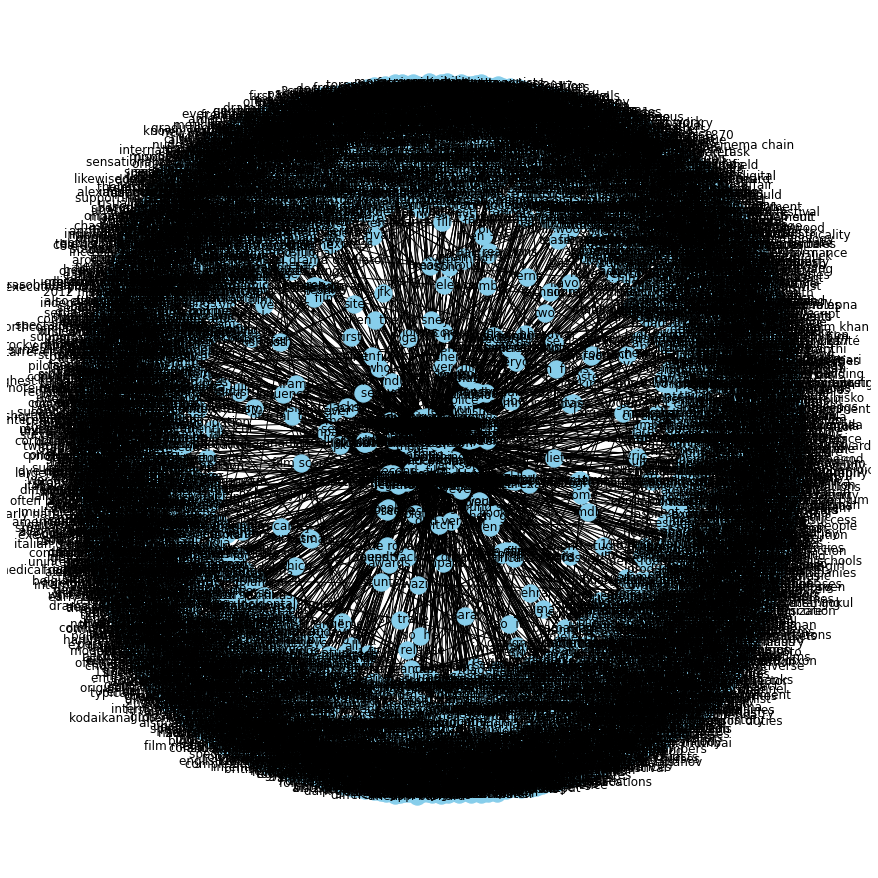

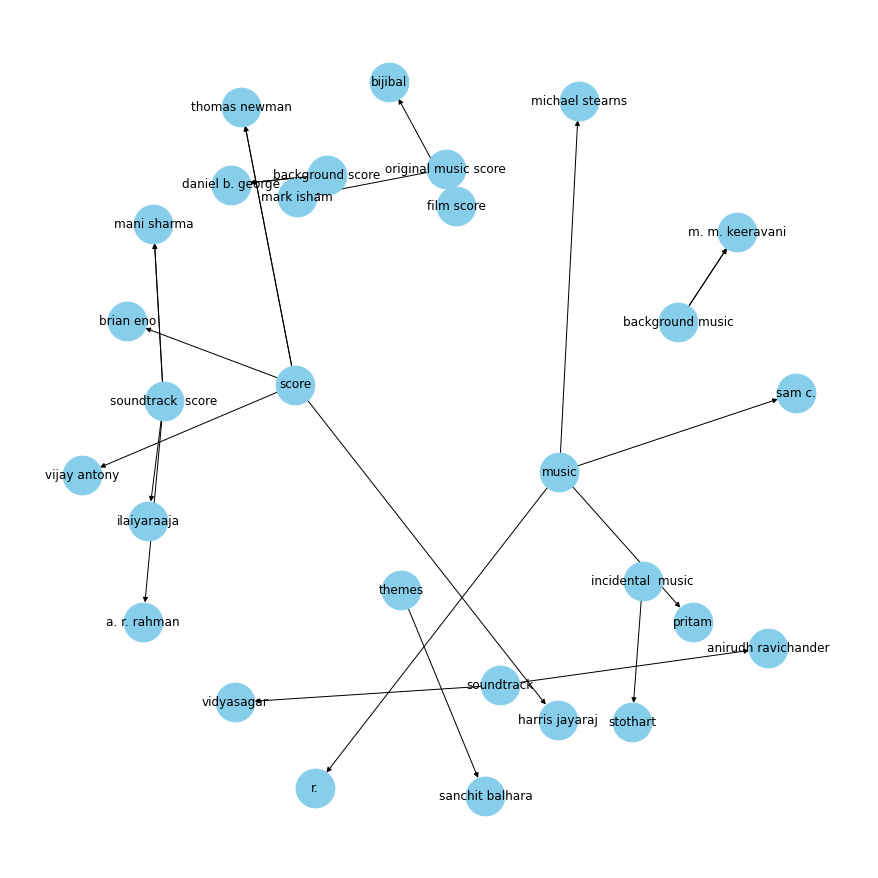

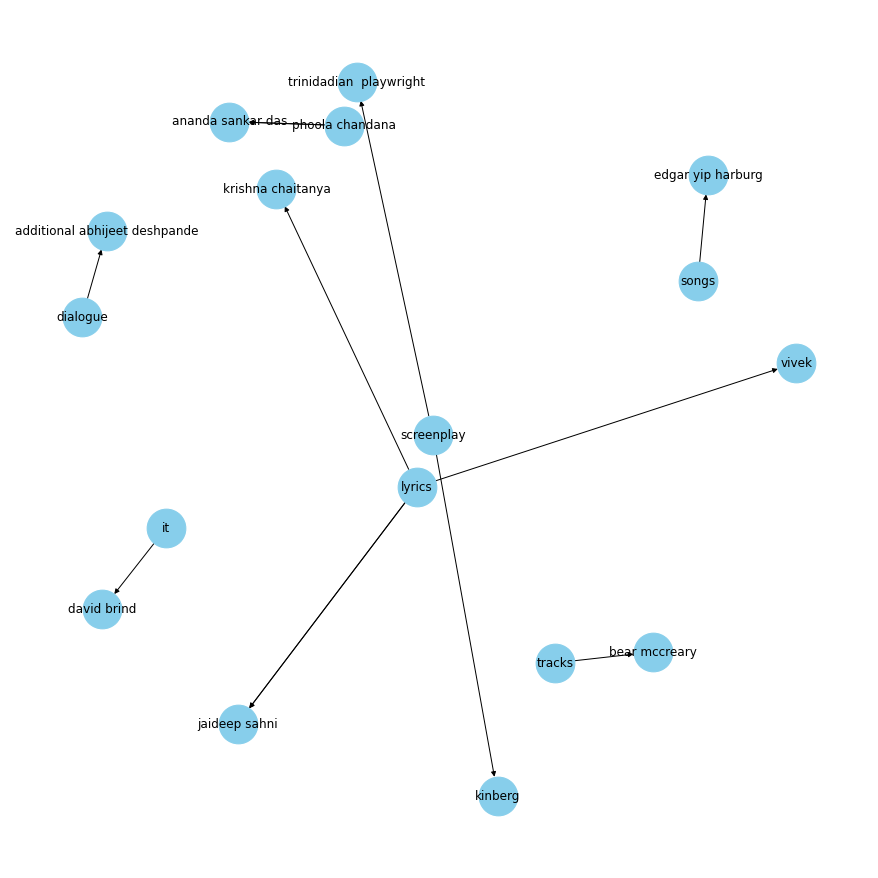

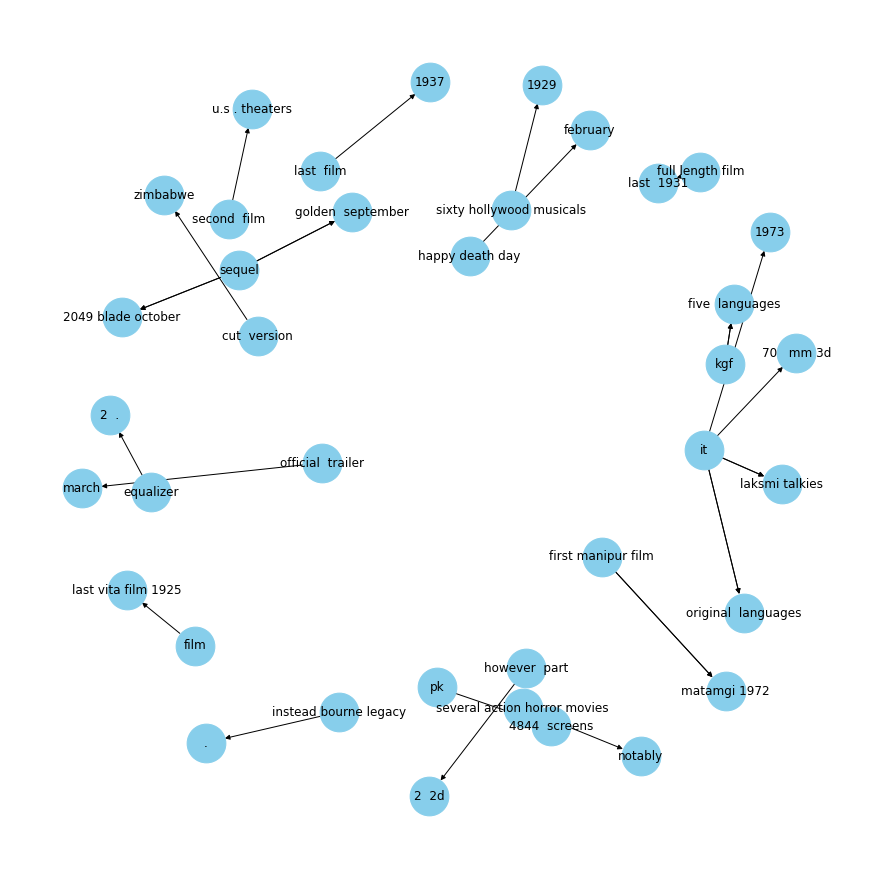

In [4]:
vAR_knowledge_graph_object = KnowledgeGraph(vAR_candidate_sentences)
vAR_knowledge_graph_object.RUN_ALL()

# Copyright Notice:

Local and international copyright laws protect
this material. Repurposing or reproducing
this material without written approval from
DeepSphere.AI violates the law.

(c) DeepSphere.AI